In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import statsmodels.api as sm
import patsy

import numpy as np

In [4]:
sns.set_style("white")

# Descriptive analysis

In [5]:
df_ops = pd.read_csv('../data/frames/ops.final')
print (len (df_ops))
print(df_ops.head(3))
print(df_ops['indeg'].max())

12733
      opid  indeg  outdeg  age  year  nuniqs      bows      sems      word
0    88651      0       0  145  1873     416  4.540803  4.251326    bonded
1  2311398      1       8   21  1997     457  3.347616  7.172658  circuits
2  2129397      0       7   27  1991     565  2.213153      -inf       UNK
3992


In [6]:
df_dblp = pd.read_csv('../data/frames/dblp.final')
print (len (df_dblp))
df_dblp.head(3)

693554


,indeg,outdeg,year,authors,nuniqs,bows,lang,word,sems,age,isunk
0,29,3,1998,2,51,21.359490,en,UNK,-inf,20,1
1,19,2,1999,5,69,13.925706,en,UNK,-inf,19,1
2,20,17,2007,3,83,27.623942,en,UNK,-inf,11,1


In [7]:
# for simplicity, let's remove docs which don't hit the lexicon
# i think we may have to do this inevitably
# where we can add a dummy variable.
exclude_list = ["UNK"] # when no innovation is present, for dblp only, i keep the word field to be UNK
drop_misses = True
if drop_misses:
    df_ops = df_ops[(~df_ops['word'].isin(exclude_list))]
    df_dblp = df_dblp[(~df_dblp['word'].isin(exclude_list))]
print (len(df_ops))
print (len(df_dblp))

7544
62474


Let's make the plots of indegree vs semantic innovativeness quartiles.

In [8]:
# quartile-ish bins of the innovation feature  
df_ops['sem_q'] = pd.qcut(df_ops['sems'],4,labels=["<25", "<50", "<75", "<100"], duplicates='drop')
df_dblp['sem_q'] = pd.qcut(df_dblp['sems'],4, labels=["<25", "<50", "<75", "<100"], duplicates='drop')

Text(0,0.5,'')

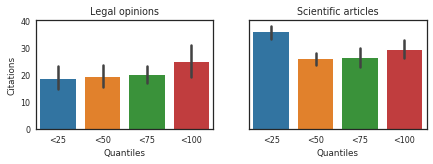

In [9]:
sns.set_context("paper")
fig,ax = plt.subplots(1,2,figsize=[7,2],sharey=True)

sns.barplot(y='indeg',x='sem_q',data=df_ops,ax=ax[0]);
ax[0].set_title('Legal opinions')
ax[0].set_xlabel('Quantiles')
ax[0].set_ylabel('Citations')
sns.barplot(y='indeg',x='sem_q',data=df_dblp,ax=ax[1]);
ax[1].set_title('Scientific articles');
ax[1].set_xlabel('Quantiles')
ax[1].set_ylabel('')

For **OPS**: Already looks pretty decent!

For **DBLP**: I tried different quantiles, but the story remains consistent: highly progressive *as well as* highly conservative papers get more citations! 

My guess is that the conservative papers are dominated by older seminal papers. Let's draw a histogram of the years in the lower quartile.

Not entirely conclusive, but there is a slight tendency towards the later years. Correction for age might be necessary. Let's look at the 2000's.

### Correction for age: DBLP (2000's only) 

In [11]:
df_dblp_2000s = df_dblp[(df_dblp["year"] > 2000) & (df_dblp["year"] <= 2010)]
print (len(df_dblp_2000s))

15207


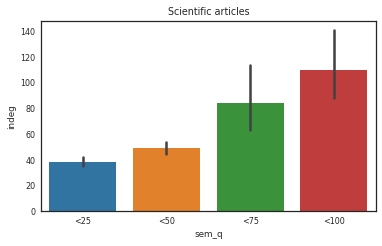

In [12]:
sns.set_context("paper")
fig,ax = plt.subplots(1,1,figsize=[6,3.5])
sns.barplot(y='indeg',x='sem_q',data=df_dblp_2000s,ax=ax);
ax.set_title('Scientific articles');

I also tried other decades: 90's and 2010's. The plot look reasonable. If you go more in the past, there are less progressive papers so the variance is high.

Lets also try something like that for OPS!

In [17]:
df_ops_80s_to_2010s = df_ops[(df_ops["year"] > 1980) & (df_ops["year"] <= 2010)]
print (len(df_ops_80s_to_2010s))

5178


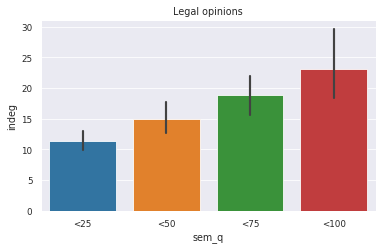

In [18]:
sns.set_context("paper")
fig,ax = plt.subplots(1,1,figsize=[6,3.5])
sns.barplot(y='indeg',x='sem_q',data=df_ops_80s_to_2010s,ax=ax);
ax.set_title('Legal opinions');

Again, other periods all look decent!

Lets keep it consistent for both and draw a shared plot.

(-0.5900000000000001, 3.5900000000000003, 0.0, 148.17603060233162)

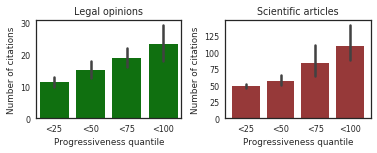

In [18]:
FROM=1980
TO=2010

df_ops["logdeg"] = np.log1p(df_ops["indeg"])

sns.set_context ("paper")
fig,ax = plt.subplots (1,2, figsize=(6,1.8), sharey=False)
sns.barplot (y="indeg", x="sem_q", data=df_ops[(df_ops["year"] > FROM) & (df_ops["year"] <= TO)], ax=ax[0], color='green')
ax[0].set_title ("Legal opinions")
ax[0].set_ylabel ("Number of citations")
ax[0].set_xlabel ("Progressiveness quantile")

df_dblp["logdeg"] = np.log1p(df_dblp["indeg"])
sns.barplot (y="indeg", x="sem_q", data=df_dblp[(df_dblp["year"] > FROM) & (df_dblp["year"] <= TO)], ax=ax[1], color='brown')
ax[1].set_title ("Scientific articles")
ax[1].set_ylabel ("Number of citations")
ax[1].set_xlabel ("Progressiveness quantile")

plt.subplots_adjust(wspace=.3)
plt.axis('tight')
#plt.savefig('cites-by-progressiveness.pdf', bbox_inches='tight')


# Regression

In [76]:
from scipy.stats.distributions import chi2

## OPS

In [68]:
formulas_ops = ["indeg ~ age + outdeg + nuniqs"]
formulas_ops.append(formulas_ops[0]+" + bows")
formulas_ops.append(formulas_ops[1]+" + sems")
formulas_ops.append(formulas_ops[1]+" + sem_q")

In [69]:
results_ops = []
for formula in formulas_ops:
    Y,X = patsy.dmatrices(formula,data=df_ops)
    results_ops.append(sm.GLM(Y, X, family=sm.families.Poisson()).fit())

In [73]:
lls = [result.llf for result in results_ops]
print(lls)

[-231777.6622467888, -228538.42492873129, -228535.20149221225, -227663.12367789674]


In [75]:
for i,ll_0 in enumerate(lls):
    for j,ll_1 in enumerate(lls[:i]):
        chi2_score = ll_0-ll_1
        dof = len(formulas_ops[i].split("+")) - len(formulas_ops[j].split('+'))
        if i == 3: dof += 2 #quartiles
        print(i,j,f'\\chi^2_{dof} = {chi2_score:.2f}, p < {chi2.sf(chi2_score, dof):.3e}')

1 0 \chi^2_1 = 3239.24, p < 0.000e+00
2 0 \chi^2_2 = 3242.46, p < 0.000e+00
2 1 \chi^2_1 = 3.22, p < 7.259e-02
3 0 \chi^2_4 = 4114.54, p < 0.000e+00
3 1 \chi^2_3 = 875.30, p < 2.015e-189
3 2 \chi^2_2 = 872.08, p < 4.273e-190


In [77]:
print(results_ops[3].summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  indeg   No. Observations:                 7544
Model:                            GLM   Df Residuals:                     7536
Model Family:                 Poisson   Df Model:                            7
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.2766e+05
Date:                Mon, 10 Dec 2018   Deviance:                   4.3342e+05
Time:                        17:09:33   Pearson chi2:                 2.49e+06
No. Iterations:                     8   Covariance Type:             nonrobust
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         1.6911      0.008    208.694      0.000       1.675       1.707
sem_q[T.<50]      0.2007      0.008     25.

## DBLP

In [38]:
formulas_dblp = ["indeg ~ age + outdeg + authors + nuniqs"]
formulas_dblp.append(formulas_dblp[0]+" + bows")
formulas_dblp.append(formulas_dblp[1]+" + sems")
formulas_dblp.append(formulas_dblp[1]+" + sem_q")

In [40]:
results_dblp = []
for formula in formulas_dblp:
    Y,X = patsy.dmatrices(formula,data=df_dblp)
    results_dblp.append(sm.GLM(Y, X, family=sm.families.Poisson()).fit())

In [67]:
lls = [result.llf for result in results_dblp]
print(lls)

[-3085945.1291966727, -3085890.6035801102, -3057183.8619055743, -3050473.686447588]


In [65]:
for i,ll_0 in enumerate(lls):
    for j,ll_1 in enumerate(lls[:i]):
        chi2_score = ll_0-ll_1
        dof = len(formulas_dblp[i].split("+")) - len(formulas_dblp[j].split('+'))
        if i == 3: dof += 2 #quartiles
        print(i,j,f'\\chi^2_{dof} = {chi2_score:.0f}, p < {chi2.sf(chi2_score, dof):.3e}')

1 0 \chi^2_1 = 55, p < 1.534e-13
2 0 \chi^2_2 = 28761, p < 0.000e+00
2 1 \chi^2_1 = 28707, p < 0.000e+00
3 0 \chi^2_4 = 35471, p < 0.000e+00
3 1 \chi^2_3 = 35417, p < 0.000e+00
3 2 \chi^2_2 = 6710, p < 0.000e+00


The coefficients are statistically significant, plus the improvement in goodness of fit is high.

**Write the results as Latex tables**

In [114]:
def get_latex_table_string (model_results, coeff):
    goodnames = {
        "Intercept": "Constant",
        "sem_q[T.<50]": "Prog. Q2",
        "sem_q[T.<75]": "Prog. Q3",
        "sem_q[T.<100]": "Prog. Q4",
        "age": "Age",
        "outdeg": "Outdegree",
        "bows": "BoWs",
        "nuniqs": "Length",
        "authors": "No. of Authors",
        "sems": "Progressiveness"
    }
    cols = [" " 
            if coeff not in model_result.model.exog_names 
            else "{0:.4f}".format(round(model_result.params[model_result.model.exog_names.index(coeff)], 4)) 
            for model_result in model_results]
    return "&".join ([goodnames[coeff]] + cols) + "\\\\"

def get_latex_stderror_string (model_results, coeff):
    goodnames = {
        "Intercept": "Constant",
        "sem_q[T.<50]": "Prog. Q2",
        "sem_q[T.<75]": "Prog. Q3",
        "sem_q[T.<100]": "Prog. Q4",
        "age": "Age",
        "outdeg": "Outdegree",
        "bows": "BoWs",
        "nuniqs": "Length",
        "authors": "No. of Authors",
        "sems": "Progressiveness"
    }
    cols = [" " 
            if coeff not in model_result.model.exog_names 
            else "({0:.4f})".format(round(model_result.bse[model_result.model.exog_names.index(coeff)], 4)) 
            for model_result in model_results]
    
    #cols = list (map (lambda x:"({0})".format (x), cols))
    
    return "&".join ([" "] + cols) + "\\\\[4pt]"

def get_latex_ll_string (model_results):
    cols = ["{0}".format(str(int(round(model_result.llf)))) for model_result in model_results]
    return "&".join (["Log Likelihood"] + cols) 

In [115]:
def ops_latex(model_results, coeffs_order):    
    print ("\\begin{table*}[t!]\n")
    print ("\centering")
    print ("\small\n")
    # header part
    print ("\\begin{tabular}{lrrrr}")
    print ("\\toprule\n")
    print ("& & Models & &\\\\\n")
    print ("\midrule\n")
    print ("Predictors & M1 & M2 & M3 & M4 \\\\\n")
    print ("\\toprule\n")
    # core part
    
    for coeff in coeffs_order:
        print (get_latex_table_string(model_results , coeff))
        print (get_latex_stderror_string (model_results, coeff))
    
    print (get_latex_ll_string (model_results))    
    print ("\\\\")
    print ("\\bottomrule\n")
    print ("\\end{tabular}\n")
    print ("\caption{The results from regressions to predict the number of citations that a legal opinion receives.}\n")
    print ("\label{tab:legal-regression}\n")
    
    print ("\end{table*}\n")

In [116]:
ops_latex ([ops_po_results1, ops_po_results2, ops_po_results3, ops_po_results4], 
           ["Intercept", "outdeg", "age", "nuniqs", "bows", "sems", "sem_q[T.<50]", "sem_q[T.<75]", "sem_q[T.<100]"])

\begin{table*}[t!]

\centering
\small

\begin{tabular}{lrrrr}
\toprule

& & Models & &\\

\midrule

Predictors & M1 & M2 & M3 & M4 \\

\toprule

Constant&1.8171&1.9246&1.9210&1.6911\\
 &(0.0051)&(0.0053)&(0.0055)&(0.0081)\\[4pt]
Outdegree&0.0150&0.0089&0.0088&0.0086\\
 &(0.0001)&(0.0002)&(0.0002)&(0.0002)\\[4pt]
Age&0.0155&0.0140&0.0141&0.0156\\
 &(0.0001)&(0.0001)&(0.0001)&(0.0001)\\[4pt]
Length&0.0003&0.0004&0.0004&0.0004\\
 &(0.0000)&(0.0000)&(0.0000)&(0.0000)\\[4pt]
BoWs& &0.0002&0.0002&0.0002\\
 & &(0.0000)&(0.0000)&(0.0000)\\[4pt]
Progressiveness& & &0.0002& \\
 & & &(0.0001)& \\[4pt]
Prog. Q2& & & &0.2007\\
 & & & &(0.0079)\\[4pt]
Prog. Q3& & & &0.2566\\
 & & & &(0.0082)\\[4pt]
Prog. Q4& & & &0.3336\\
 & & & &(0.0082)\\[4pt]
Log Likelihood&-231778&-228538&-228535&-227663
\\
\bottomrule

\end{tabular}

\caption{The results from regressions to predict the number of citations that a legal opinion receives.}

\label{tab:legal-regression}

\end{table*}



In [122]:
def dblp_latex(model_results, coeffs_order):    
    print ("\\begin{table*}[t!]\n")
    print ("\centering\n")
    print ("\small\n")
    # header part
    print ("\\begin{tabular}{lrrrr}")
    print ("\\toprule\n")
    print ("& & Models & &\\\\\n")
    print ("\midrule\n")
    print ("Predictors & (1) & (2) & (3) & (4) \\\\\n")
    print ("\\toprule\n")
    # core part
    
    for coeff in coeffs_order:
        print (get_latex_table_string(model_results , coeff))
        print (get_latex_stderror_string (model_results, coeff))
    
    print (get_latex_ll_string (model_results))    
    print ("\\\\")
    print ("\\bottomrule\n")
    print ("\\end{tabular}\n")
    print ("\caption{The results from regressions to predict the number of citations that a scientific article receives.}\n")
    print ("\label{tab:legal-abstracts}\n")
    
    print ("\end{table*}\n")

In [134]:
import datetime

In [137]:
print(datetime.datetime.now())

2018-12-10 20:08:33.797486


In [133]:
chi2.cdf(6,3)

0.8883897749052874

In [132]:
1 - chi2.sf(6,3)

0.8883897749052874

In [124]:
print("{%s}"%('foo'))

{foo}


In [123]:
dblp_latex (results_dblp, 
           ["Intercept", "outdeg", "age", "nuniqs", "authors", "bows", "sems", "sem_q[T.<50]", "sem_q[T.<75]", "sem_q[T.<100]"])

\begin{table*}[t!]

\centering

\small

\begin{tabular}{lrrrr}
\toprule

& & Models & &\\

\midrule

Predictors & (1) & (2) & (3) & (4) \\

\toprule

Constant&1.7929&1.7964&1.6389&1.4181\\
 &(0.0025)&(0.0026)&(0.0027)&(0.0031)\\[4pt]
Outdegree&0.0166&0.0166&0.0165&0.0162\\
 &(0.0000)&(0.0000)&(0.0000)&(0.0000)\\[4pt]
Age&0.0863&0.0863&0.0933&0.0973\\
 &(0.0001)&(0.0001)&(0.0001)&(0.0001)\\[4pt]
Length&0.0047&0.0047&0.0045&0.0047\\
 &(0.0000)&(0.0000)&(0.0000)&(0.0000)\\[4pt]
No. of Authors&0.0406&0.0406&0.0418&0.0421\\
 &(0.0002)&(0.0002)&(0.0002)&(0.0002)\\[4pt]
BoWs& &0.0000&0.0000&0.0000\\
 & &(0.0000)&(0.0000)&(0.0000)\\[4pt]
Progressiveness& & &0.0138& \\
 & & &(0.0001)& \\[4pt]
Prog. Q2& & & &0.1876\\
 & & & &(0.0021)\\[4pt]
Prog. Q3& & & &0.4200\\
 & & & &(0.0023)\\[4pt]
Prog. Q4& & & &0.5862\\
 & & & &(0.0023)\\[4pt]
Log Likelihood&-3085945&-3085891&-3057184&-3050474
\\
\bottomrule

\end{tabular}

\caption{The results from regressions to predict the number of citations that a s